In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as io

import ephys_extractor as efex
import ephys_features as ft

In [2]:
ephys_dir = '../data/scMNC/mouse_visual_cortex/raw_data/'
ephys_names = []; ephys_data = []
for root, _, files in os.walk(ephys_dir + 'ephys-patch-seq'):
    if files:
        for file in files:
            ephys_names.append(file)
            ephys_data.append(io.loadmat(os.path.join(root, file)))

In [3]:
# https://github.com/berenslab/layer4/blob/master/ephys/GetFeaturesPipelineL4.ipynb
def data_preparation(data, el_num = 2, current_step = 20):
    """Analyse the data in dictionary format (assumes a certain outlook of the data) and return the voltage traces, 
    stimulus current magnitudes for all traces, the time and the current index for which the current magnitude equals 0 pA.

    Parameters
    ----------
    data : dictionary full of voltage (V) and time (s) traces
    el_num : integer, from which electrode number has been measured (optional, 2 by default)
    current_step : float, which current step (pA) has been used between consecutive experiments (optional, 20 by default)
    
    Returns
    -------
    voltage : numpy 2D array of voltage traces (mV)
    time : numpy 1D array of time points (s)
    current : numpy 1D array of current stimulus magnitudes
    curr_index_0 : integer of current index where the current = 0 pA
    """
    
    
    
    # All the keys in the dictionary should have the form "Trace_1_j_c_el" where j represents a certain number which could
    # be different between cells/samples, therefore we will store this number as num. c represents the current stimulus
    # magnitude index, el the electrode number. They usually always record from electrode number el = 2.
    
    # Random initialisations
    num = 2
    n_samp = 22500
    dt = 4e-05
    for key in list(data)[1:6]:
        if key.split('_')[0] == "Trace":
            num = key.split('_')[2]
            n_samp = data[key].shape[0] # Amount of timepoints
            dt = data[key][1, 0] - data[key][0, 0] # Time step
            break
    time = np.arange(0,n_samp*dt,dt)
    
    # We pick random voltage traces to look for the resting membrane voltage
    Vm_tuple = []
    
    # Check whether we have hyperpolarisation in the beginning, otherwise the electrode where spikes have been recorded must have
    # been a different one
    object_ephys = efex.EphysSweepFeatureExtractor(t = time, v = 1000*data['Trace_{}_{}_{}_{}'.format(1, num, 1, el_num)][:, 1], \
                                                   start = 0.1, end = 0.7, filter = 10)
    voltage_deflection_v, _ = object_ephys.voltage_deflection()
    Vm = object_ephys._get_baseline_voltage()
    V_defl = voltage_deflection_v
    if  np.abs(Vm - V_defl) < 2:
        el_num = 1
        while np.abs(Vm - V_defl) < 2:
            object_ephys = efex.EphysSweepFeatureExtractor(t = time, v = 1000*data['Trace_{}_{}_{}_{}'.format(1, num, 1, el_num)][:, 1], \
                                                   start = 0.1, end = 0.7, filter = 10)
            Vm = object_ephys._get_baseline_voltage()
            V_defl, _ = object_ephys.voltage_deflection()
            if el_num == 1:
                el_num = 3
            else: el_num += 1
        el_num = el_num - 1
    #for i in np.arange(1, 12, 1):
    #    voltage_trace = data['Trace_1_{}_{}_{}'.format(num, i, el_num)][:, 1]
    #    object_ephys = efex.EphysSweepFeatureExtractor(t = time, v = 1000*voltage_trace, start = 0.1, end = 0.7, filter = 10)
    #    Vm = object_ephys._get_baseline_voltage()
    #    Vm_tuple.append(Vm)
    #Vm = np.mean(np.array(Vm_tuple))
    

    
    Amount_Of_Electrodes = np.max([int(g.split('_')[-1]) if (g.split('_')[0] == 'Trace') else 0 for g in list(data.keys())])
    
    # stim_paradigm_num is the number of current stimulus magnitudes that were used
    stim_paradigm_num = (np.array(list(data)).size - 3)/Amount_Of_Electrodes
                                    # 3 keys should just be '__globals__', '__header__', and '__version__'
    
    curr_index_0 = 0 # Current stimulus magnitude index that corresponds to stimulating the cell with 0 pA
    
    # Trace with the least amount of variance in the trace is assumed to be the trace corresponding to stimulating the cell
    # with 0 pA stimulation current
    best = np.var(1000*data['Trace_1_{}_{}_{}'.format(num, 1, el_num)][:, 1])
    #best = np.abs(np.mean(1000*data['Trace_1_{}_{}_{}'.format(num, 1, el_num)][:, 1]) - Vm)
    for i in np.arange(2, stim_paradigm_num + 1, 1, dtype = 'int'):
        best_temp = np.var(1000*data['Trace_1_{}_{}_{}'.format(num, i, el_num)][:, 1])
        #best_temp = np.abs(np.mean(1000*data['Trace_1_{}_{}_{}'.format(num, i, el_num)][:, 1]) - Vm)
        if  best_temp < best:
            best = best_temp
            curr_index_0 = i
    
    start_current_impulse = -(curr_index_0 - 1)*current_step # - 1 since in the dictionary we start at 1 (not at zero)    
    stop_current_impulse = start_current_impulse + (current_step*stim_paradigm_num)
    current = np.arange(start_current_impulse, stop_current_impulse, current_step)
    
    
    # voltage will give us the voltage response for all different current steps
    voltage = np.zeros((n_samp,len(current)))
    # print('Starting current: ', current[0])
    for c, C in enumerate(current):
        voltage[:,c] = 1000*data['Trace_1_{}_{}_{}'.format(num, c+1, el_num)][:,1] # c+1: goes from 1 to end of possible current
                                                                                   # stimulation magnitudes
    
    return time, current, voltage, (curr_index_0 - 1) # -1 since the current and voltage vector start at 0

In [24]:
base_time = data_preparation(ephys_data[0], el_num = 2)[0]
crop = (np.argwhere(base_time >= .1)[0, 0], np.argwhere(base_time > .7)[0, 0])  # .1 to .7
base_time = base_time[crop[0]:crop[1]]
exp = []
for i in range(len(ephys_data)):
    # Pull data
    time, current, voltage, curr_index_0 = data_preparation(ephys_data[i], el_num = 2)
    time, voltage = time[crop[0]:crop[1]], voltage[crop[0]:crop[1]]
    assert (time == base_time).all()
    
    # Add mean response
    assert current.shape[0] == voltage.shape[1]
    # print(f'Averaging over {voltage.shape[1]} sweeps')
    for c, v in zip(current, voltage.T):
        exp.append({'name': ephys_names[i], 'stim': c, 'resp': v})

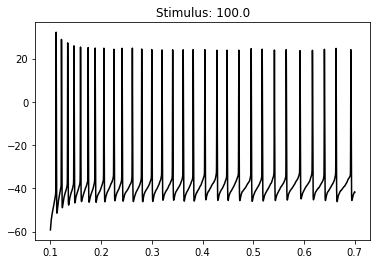

In [25]:
idx = 15
plt.plot(base_time, exp[idx]['resp'], 'k-')
plt.title(f'Stimulus: {exp[idx]["stim"]}');

In [26]:
print(f'Saving {len(exp)} ephys sweeps...')
np.save(ephys_dir + 'exp.npy', exp)
# np.load(ephys_dir + 'exp.npy', allow_pickle=True)

Saving 8814 ephys sweeps...
